<a href="https://colab.research.google.com/github/ankitmeena7007-beep/Experiment-10/blob/main/Experiment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


!pip install ucimlrepo --quiet

import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree


In [ ]:


adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets


df = pd.concat([X, y], axis=1)
df.dropna(inplace=True)


df['income'] = df['income'].apply(lambda x: 1 if '>50K' in x else 0)

for col in df.select_dtypes(include=['object']).columns:
    if col != 'income':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))


X = df.drop('income', axis=1)
y = df['income']


X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(" Data loaded successfully")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


 Data loaded successfully
Train: (30476, 14), Val: (7620, 14), Test: (9525, 14)


In [ ]:


class DecisionTreeCustom:
    def __init__(self, criterion='gini', max_depth=None, min_samples_split=2, min_impurity_decrease=1e-6):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.tree = None

    def _impurity(self, y):
        classes, counts = np.unique(y, return_counts=True)
        p = counts / counts.sum()
        if self.criterion == 'gini':
            return 1 - np.sum(p ** 2)
        else:
            return -np.sum(p * np.log2(p + 1e-9))

    def _best_split(self, X, y):
        best_gain, best_feature, best_threshold = 0, None, None
        parent_impurity = self._impurity(y)
        n_features = X.shape[1]

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_idx = X[:, feature] <= t
                right_idx = X[:, feature] > t
                if left_idx.sum() < self.min_samples_split or right_idx.sum() < self.min_samples_split:
                    continue
                left_impurity = self._impurity(y[left_idx])
                right_impurity = self._impurity(y[right_idx])
                n = len(y)
                child_impurity = (left_idx.sum()/n)*left_impurity + (right_idx.sum()/n)*right_impurity
                info_gain = parent_impurity - child_impurity
                if info_gain > best_gain + self.min_impurity_decrease:
                    best_gain, best_feature, best_threshold = info_gain, feature, t
        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1:
            return np.unique(y)[0]
        if self.max_depth and depth >= self.max_depth:
            return np.bincount(y).argmax()

        feature, threshold = self._best_split(X, y)
        if feature is None:
            return np.bincount(y).argmax()

        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold
        left_subtree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx], y[right_idx], depth + 1)
        return (feature, threshold, left_subtree, right_subtree)

    def fit(self, X, y):
        self.tree = self._build_tree(X.values, y.values)

    def _predict_one(self, x, tree):
        if not isinstance(tree, tuple):
            return tree
        feature, threshold, left, right = tree
        if x[feature] <= threshold:
            return self._predict_one(x, left)
        else:
            return self._predict_one(x, right)

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X.values])


In [ ]:


def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    pre = precision_score(y, y_pred, average='binary', zero_division=0)
    rec = recall_score(y, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y, y_pred)
    return {"accuracy": acc, "precision": pre, "recall": rec, "f1": f1, "confusion_matrix": cm}


In [ ]:


configs = [
    {'criterion': 'gini', 'max_depth': 2},
    {'criterion': 'gini', 'max_depth': 4},
    {'criterion': 'entropy', 'max_depth': 6},
    {'criterion': 'entropy', 'max_depth': None},
]

results = {}

for cfg in configs:
    print(f"\n Config: {cfg}")
    model = DecisionTreeCustom(criterion=cfg['criterion'], max_depth=cfg['max_depth'])
    model.fit(X_train, y_train)
    res = evaluate_model(model, X_val, y_val)
    results[str(cfg)] = res
    print(res)



 Config: {'criterion': 'gini', 'max_depth': 2}
{'accuracy': 0.8213910761154856, 'precision': 0.7413461538461539, 'recall': 0.4138486312399356, 'f1': 0.5311746469169825, 'confusion_matrix': array([[5488,  269],
       [1092,  771]])}

 Config: {'criterion': 'gini', 'max_depth': 4}
{'accuracy': 0.8451443569553806, 'precision': 0.7612853863810253, 'recall': 0.5340848094471283, 'f1': 0.6277602523659306, 'confusion_matrix': array([[5445,  312],
       [ 868,  995]])}

 Config: {'criterion': 'entropy', 'max_depth': 6}
{'accuracy': 0.8476377952755906, 'precision': 0.7763779527559055, 'recall': 0.5292538915727322, 'f1': 0.6294286626236834, 'confusion_matrix': array([[5473,  284],
       [ 877,  986]])}

 Config: {'criterion': 'entropy', 'max_depth': None}
{'accuracy': 0.8199475065616798, 'precision': 0.6426496223126089, 'recall': 0.5936661298980139, 'f1': 0.6171875, 'confusion_matrix': array([[5142,  615],
       [ 757, 1106]])}


In [ ]:


print("\n\n==============================")
print(" Scikit-learn Decision Tree")
print("==============================")

sk_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)
sk_model.fit(X_train, y_train)
sk_results = evaluate_model(sk_model, X_val, y_val)
print(sk_results)




 Scikit-learn Decision Tree
{'accuracy': 0.8451443569553806, 'precision': 0.7612853863810253, 'recall': 0.5340848094471283, 'f1': 0.6277602523659306, 'confusion_matrix': array([[5445,  312],
       [ 868,  995]])}


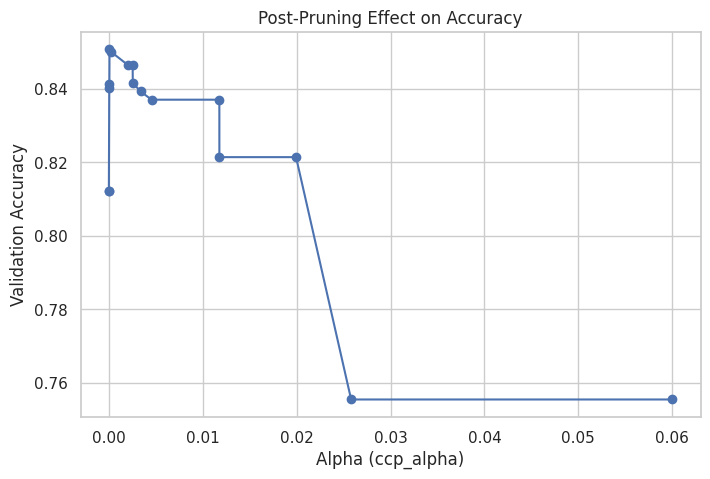

In [ ]:


path = sk_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

models = []
for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    models.append(model)

acc_scores = [model.score(X_val, y_val) for model in models]

plt.figure(figsize=(8,5))
plt.plot(ccp_alphas, acc_scores, marker='o')
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Validation Accuracy")
plt.title("Post-Pruning Effect on Accuracy")
plt.show()



 Final Model on Test Data: {'accuracy': 0.848503937007874, 'precision': 0.740506329113924, 'recall': 0.5961783439490446, 'f1': 0.6605504587155964, 'confusion_matrix': array([[6678,  492],
       [ 951, 1404]])}


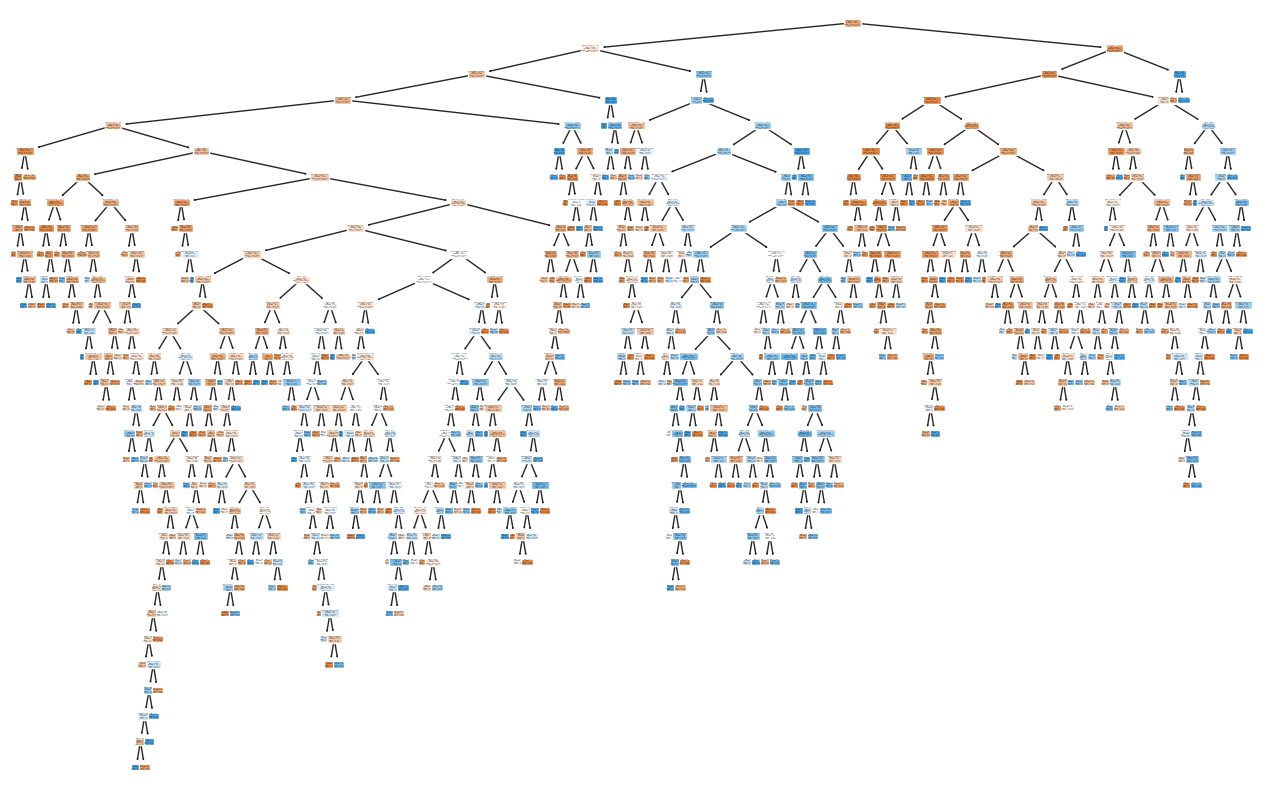

In [ ]:


best_alpha = ccp_alphas[np.argmax(acc_scores)]
final_model = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
final_model.fit(X_train, y_train)

final_results = evaluate_model(final_model, X_test, y_test)
print("\n Final Model on Test Data:", final_results)


plt.figure(figsize=(16,10))
tree.plot_tree(final_model, filled=True, feature_names=X.columns, class_names=['<=50K','>50K'])
plt.show()
